<div style="text-align: center;">

# Feature Selection and Dimensionality Reduction on SECOM Dataset

</div>

**Notebook:** `CDM__5_Final.ipynb`

**Project Goal:** Compare and evaluate different feature selection techniques—specifically Filter (Mutual Information), Wrapper (RFE), and Dimensionality Reduction (SVD)—to identify critical process factors in semiconductor manufacturing.

**Abstract:** This notebook utilizes the SECOM (Semiconductor Manufacturing) dataset to address high-dimensional fault detection challenges. The workflow begins with data preprocessing, including the removal of zero-variance columns, median imputation for missing values, and standardization. We then implement and compare three distinct feature ranking/selection strategies:
1. **Mutual Information (Filter Method):** Captures non-linear dependencies between features and the target.
2. **Recursive Feature Elimination (Wrapper Method):** Uses a Random Forest estimator to iteratively select optimal features.
3. **Singular Value Decomposition (SVD):** Computes feature importance scores based on singular values and loadings ($U \Sigma V^T$).

The analysis concludes by evaluating the selected features based on **execution time**, **feature overlap** (Venn diagrams), and their impact on downstream model performance (Accuracy and F1-score) using Logistic Regression and Random Forest classifiers.

In [1]:
# -----------------------------------------------------------
# Core Libraries
# -----------------------------------------------------------
import numpy as np                 # Numerical operations
import pandas as pd                # Data manipulation
import matplotlib.pyplot as plt    # Visualization
from matplotlib_venn import venn2  # Venn diagrams
import time                        # Timing operations

# -----------------------------------------------------------
# Machine Learning: Preprocessing & Selection
# -----------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------
# Machine Learning: Models & Metrics
# -----------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------------------------------------
# Plotting Configuration
# -----------------------------------------------------------
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)
plt.style.use('ggplot')

# -----------------------------------------------------------
# Suppress Warnings
# -----------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
# -----------------------------------------------------------
# 1.1 Load Dataset
# -----------------------------------------------------------
url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
url_labels = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

print("Loading SECOM dataset...")
# Features are space-separated
X_raw = pd.read_csv(url_data, sep="\s+", header=None)
# Labels are space-separated, taking the first column (class)
y_raw = pd.read_csv(url_labels, sep="\s+", header=None).iloc[:, 0]

print(f"Original Shape: {X_raw.shape}")

# -----------------------------------------------------------
# 1.1 Remove Zero Variance Columns
# -----------------------------------------------------------
X_clean = X_raw.loc[:, X_raw.var() != 0]

print(f"Shape after Constant Removal: {X_clean.shape}")

# -----------------------------------------------------------
# 1.1 Median Imputation
# -----------------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_clean)

# -----------------------------------------------------------
# 1.2 Standardization (Crucial for SVD)
# -----------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Convert back to DataFrame for easier indexing later
X_final = pd.DataFrame(X_scaled, columns=X_clean.columns)
y_final = y_raw.copy()

Loading SECOM dataset...
Original Shape: (1567, 590)
Shape after Constant Removal: (1567, 474)


In [3]:
# -----------------------------------------------------------
# 2.1 Filter Method: Mutual Information
# -----------------------------------------------------------
print("Running Mutual Information...")
selector_mi = SelectKBest(mutual_info_classif, k=20)

start_time = time.time()
selector_mi.fit(X_final, y_final)
end_time = time.time()
mi_time = end_time - start_time

print(f"Mutual Information Execution Time: {mi_time:.2f} seconds")

# Get indices of top 20 features
mi_indices = selector_mi.get_support(indices=True)
mi_features = X_final.columns[mi_indices]
print(f"MI Selected Features (Top 5): {list(mi_features[:5])}")

# -----------------------------------------------------------
# 2.2 Wrapper Method: RFE (Random Forest)
# -----------------------------------------------------------
print("Running RFE with Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=2020, n_jobs=-1)
rfe = RFE(estimator=rf, n_features_to_select=20, step=0.1) # Step 0.1 to speed up

start_time = time.time()
rfe.fit(X_final, y_final)
end_time = time.time()
rfe_time = end_time - start_time

rfe_indices = rfe.get_support(indices=True)
rfe_features = X_final.columns[rfe_indices]

print(f"RFE Execution Time: {rfe_time:.2f} seconds")
print(f"RFE Selected Features (Top 5): {list(rfe_features[:5])}")

Running Mutual Information...
Mutual Information Execution Time: 2.82 seconds
MI Selected Features (Top 5): [40, 41, 65, 128, 130]
Running RFE with Random Forest...
RFE Execution Time: 4.88 seconds
RFE Selected Features (Top 5): [25, 26, 38, 40, 59]


In [4]:
# -----------------------------------------------------------
# 3.1 Decomposition (SVD)
# -----------------------------------------------------------
# X = U * S * Vt
# numpy.linalg.svd returns U, S (1D array of singular values), and Vt
print("Computing SVD...")
U, S, Vt = np.linalg.svd(X_final, full_matrices=False)

# -----------------------------------------------------------
# 3.2 Score Function Implementation
# -----------------------------------------------------------
def calculate_svd_scores(S, Vt):
    """
    Calculates feature importance scores based on SVD.
    Score_j = Sum( sigma_i^2 * |V_ij| ) over all components i
    """
    # Square the singular values (Eigenvalues of Covariance matrix)
    sigma_sq = S ** 2
    
    # Reshape sigma_sq for broadcasting: (K, ) -> (K, 1)
    weights = sigma_sq.reshape(-1, 1)
    
    # Absolute values of V^T (Loadings)
    abs_Vt = np.abs(Vt)
    
    # Weighted sum across all components (axis 0)
    # Shape: (K, N_features) -> Sum -> (N_features, )
    scores = np.sum(weights * abs_Vt, axis=0)
    
    return scores

start_time = time.time()
feature_scores = calculate_svd_scores(S, Vt)
end_time = time.time()
svd_time = end_time - start_time

print(f"SVD Execution Time: {svd_time:.2f} seconds")

# -----------------------------------------------------------
# 3.3 Selection
# -----------------------------------------------------------
# Create a DataFrame to rank features
df_scores = pd.DataFrame({
    'feature_idx': X_final.columns,
    'score': feature_scores
})

# Sort descending and pick top 20
svd_top20 = df_scores.sort_values(by='score', ascending=False).head(20)
svd_features = svd_top20['feature_idx'].values

print(f"SVD Selected Features (Top 5): {list(svd_features[:5])}")

Computing SVD...
SVD Execution Time: 0.00 seconds
SVD Selected Features (Top 5): [441, 170, 72, 29, 305]


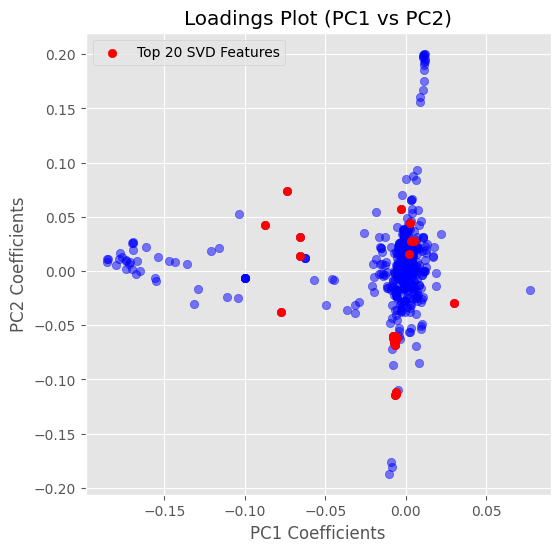

Running Stability Test (5 iterations with noise)...
Avg Overlap with Original (SVD): 18.8 / 20
Avg Overlap with Original (RFE): 12.6 / 20


In [5]:
# -----------------------------------------------------------
# 4.1 Loadings Plot (PC1 vs PC2)
# -----------------------------------------------------------
# Vt[0, :] is PC1 loadings, Vt[1, :] is PC2 loadings
pc1_loadings = Vt[0, :]
pc2_loadings = Vt[1, :]

plt.scatter(pc1_loadings, pc2_loadings, alpha=0.5, color='blue')
plt.title('Loadings Plot (PC1 vs PC2)')
plt.xlabel('PC1 Coefficients')
plt.ylabel('PC2 Coefficients')

# Highlight top SVD features
top_indices = [X_final.columns.get_loc(c) for c in svd_features]
plt.scatter(pc1_loadings[top_indices], pc2_loadings[top_indices], color='red', label='Top 20 SVD Features')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------
# 4.2 Stability Test
# -----------------------------------------------------------
def get_top_features(X_data, y_data, method='svd'):
    if method == 'svd':
        _, S_n, Vt_n = np.linalg.svd(X_data, full_matrices=False)
        sc = calculate_svd_scores(S_n, Vt_n)
        # Get indices of top 20
        return set(np.argsort(sc)[::-1][:20])
    elif method == 'rfe':
        # Using a simpler tree here for speed in loop
        sel = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=2020, n_jobs=-1), 
                  n_features_to_select=20, step=0.1)
        sel.fit(X_data, y_data)
        return set(np.where(sel.support_)[0])

print("Running Stability Test (5 iterations with noise)...")

original_svd_set = set([X_final.columns.get_loc(c) for c in svd_features])
original_rfe_set = set([X_final.columns.get_loc(c) for c in rfe_features])

svd_overlaps = []
rfe_overlaps = []

for i in range(5):
    #  Calculate how many samples is 5%
    n_samples = X_final.shape[0]
    n_noisy_samples = int(0.05 * n_samples)
    
    # Choose random indices for the rows to be noisy
    noisy_indices = np.random.choice(n_samples, n_noisy_samples, replace=False)
    
    X_noisy = X_final.copy()
    
    # Generate noise just for those rows
    # Shape of noise must match: (number of selected rows, number of features)
    noise = np.random.normal(0, 0.1, (n_noisy_samples, X_final.shape[1]))
    
    # Add noise only to the selected indices
    X_noisy.iloc[noisy_indices] += noise 
    
    # Re-run SVD Selection
    svd_new_set = get_top_features(X_noisy, y_final, method='svd')
    svd_overlaps.append(len(original_svd_set.intersection(svd_new_set)))
    
    # Re-run RFE Selection
    rfe_new_set = get_top_features(X_noisy, y_final, method='rfe')
    rfe_overlaps.append(len(original_rfe_set.intersection(rfe_new_set)))

print(f"Avg Overlap with Original (SVD): {np.mean(svd_overlaps)} / 20")
print(f"Avg Overlap with Original (RFE): {np.mean(rfe_overlaps)} / 20")

Final Comparison Table:

        Method  Accuracy  F1-Score  Selection Time (s)
0  Mutual Info  0.592357  0.696408            2.820714
1          RFE  0.783439  0.834286            4.881337
2          SVD  0.722930  0.792782            0.000000


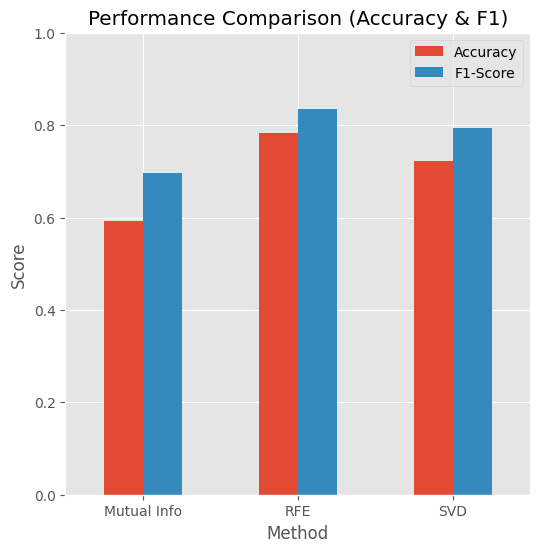

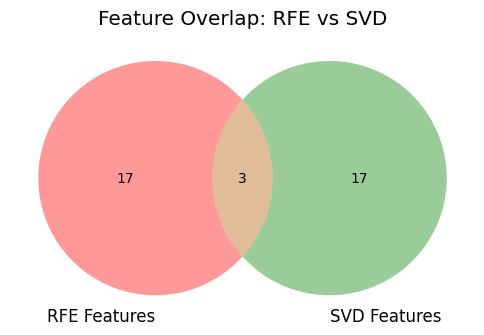

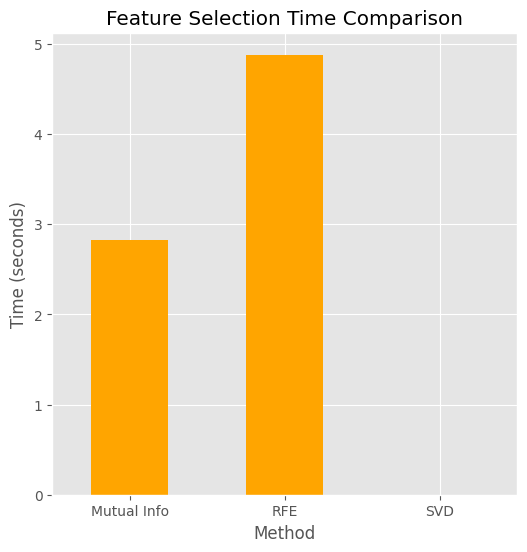

In [6]:
# -----------------------------------------------------------
# 5.1 Train & Evaluate Models 
# -----------------------------------------------------------

# Define selection times manually 
selection_times = {
    'Mutual Info': mi_time, 
    'RFE': rfe_time,         
    'SVD': svd_time           
}

feature_sets = {
    'Mutual Info': mi_features,
    'RFE': rfe_features,
    'SVD': svd_features
}

results = []

# Split Data once
X_train_full, X_test_full, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=2020)

for name, feats in feature_sets.items():
    # Subset data
    X_train_sub = X_train_full[feats]
    X_test_sub = X_test_full[feats]
    
    # Train Logistic Regression
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train_sub, y_train)
    
    # Predict
    y_pred = clf.predict(X_test_sub)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Get selection time
    sel_time = selection_times.get(name, 0)
    
    results.append({
        'Method': name, 
        'Accuracy': acc, 
        'F1-Score': f1,
        'Selection Time (s)': sel_time
    })

# -----------------------------------------------------------
# 5.2 Results
# -----------------------------------------------------------
results_df = pd.DataFrame(results)
print("Final Comparison Table:\n")
print(results_df)

# Plotting Accuracy & F1
results_df.set_index('Method')[['Accuracy', 'F1-Score']].plot(kind='bar', ylim=(0, 1.0))
plt.title('Performance Comparison (Accuracy & F1)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


# -----------------------------------------------------------
# 5.3 Venn Diagram Analysis
# -----------------------------------------------------------
# Create Sets
set_rfe = set(rfe_features)
set_svd = set(svd_features)

# Plot Venn Diagram
venn2([set_rfe, set_svd], set_labels=('RFE Features', 'SVD Features'))
plt.title('Feature Overlap: RFE vs SVD')
plt.show()

# -----------------------------------------------------------
# 5.4 Selection Time Comparison
# -----------------------------------------------------------
results_df.set_index('Method')['Selection Time (s)'].plot(kind='bar', color='orange')
plt.title('Feature Selection Time Comparison')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=0)
plt.show()